In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_formats = ['retina']
sns.set_style("white")


In [2]:
rest_small = pd.read_pickle('./restaurant_small.pkl')

In [3]:
rest_small.head()

,Success,Neighborhood,ZHVI_AllHomes,Year Opened,Month Opened
2,1,North Beach/Chinatown,969400.0,2008,4
3,1,North Beach/Chinatown,969400.0,2008,4
4,1,North Beach/Chinatown,969400.0,2008,4
9,1,Inner Mission/Bernal Heights,295000.0,1998,10
23,1,Hayes Valley/Tenderloin/North of Market,467200.0,2011,12


In [4]:
#Need to convert "Neighborhood" feature to dummy variables
rest_with_dummies = pd.concat([rest_small, pd.get_dummies(rest_small['Neighborhood'])], axis=1)
rest_with_dummies.drop('Neighborhood', axis=1, inplace=True)
rest_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6532 entries, 2 to 8898
Data columns (total 25 columns):
Success                                    6532 non-null int64
ZHVI_AllHomes                              6532 non-null float64
Year Opened                                6532 non-null int64
Month Opened                               6532 non-null int64
Bayview-Hunters Point                      6532 non-null uint8
Castro/Noe Valley                          6532 non-null uint8
Chinatown                                  6532 non-null uint8
Haight-Ashbury                             6532 non-null uint8
Hayes Valley/Tenderloin/North of Market    6532 non-null uint8
Ingelside-Excelsior/Crocker-Amazon         6532 non-null uint8
Inner Mission/Bernal Heights               6532 non-null uint8
Inner Richmond                             6532 non-null uint8
Lake Merced                                6532 non-null uint8
Marina                                     6532 non-null uint8
North Bea

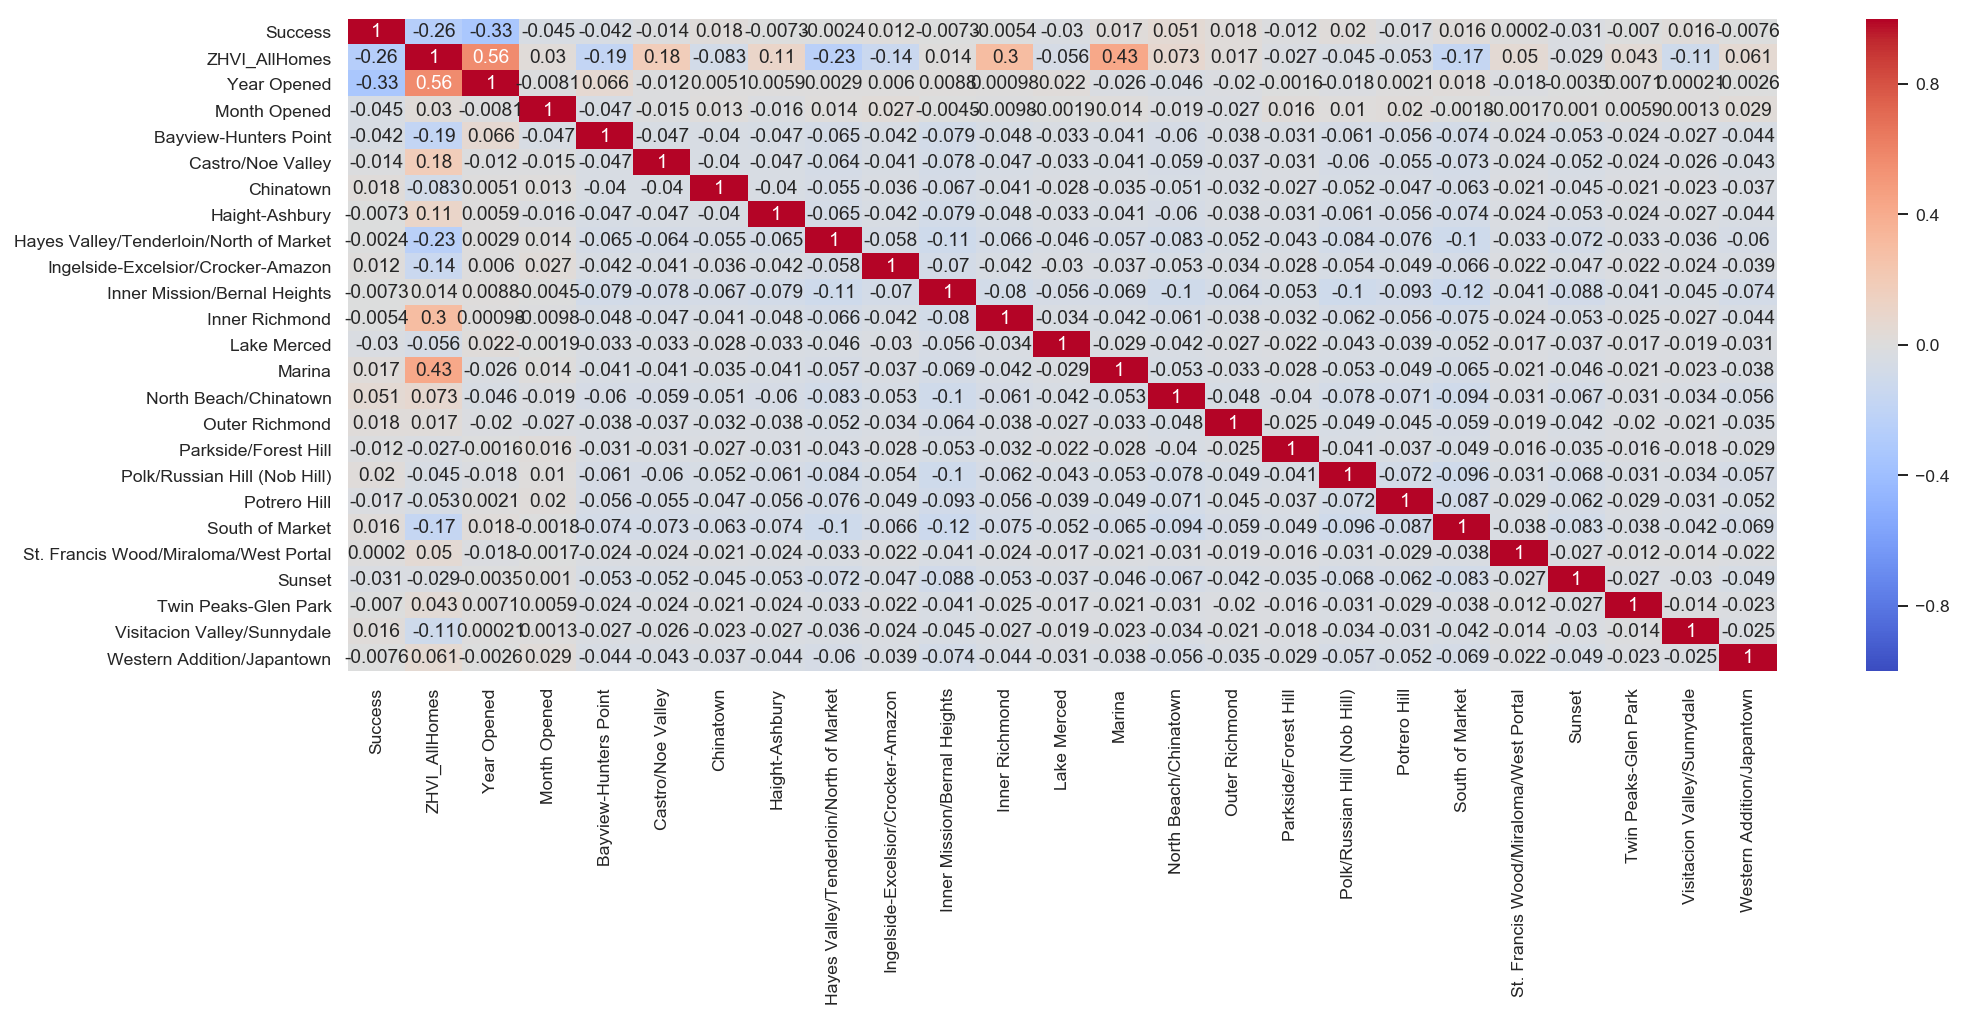

In [5]:
#Not much feature collinearity --> year opened & ZHVI close, since ZHVIs generally increase over time
plt.figure(figsize=(16, 6))
sns.set_context("paper")
sns.heatmap(rest_with_dummies.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1);

### Modeling

**Split data into data/target categories**

In [6]:
data = rest_with_dummies[['ZHVI_AllHomes', 'Year Opened', 'Month Opened', 
                          'Bayview-Hunters Point', 'Castro/Noe Valley', 
                          'Chinatown', 'Haight-Ashbury', 
                          'Hayes Valley/Tenderloin/North of Market', 
                          'Ingelside-Excelsior/Crocker-Amazon', 
                          'Inner Mission/Bernal Heights', 'Inner Richmond', 
                          'Lake Merced', 'Marina',  'North Beach/Chinatown',
                          'Outer Richmond', 'Parkside/Forest Hill', 
                          'Polk/Russian Hill (Nob Hill)', 'Potrero Hill',
                          'South of Market', 'St. Francis Wood/Miraloma/West Portal', 
                          'Sunset', 'Twin Peaks-Glen Park', 
                          'Visitacion Valley/Sunnydale', 'Western Addition/Japantown']]

target = rest_with_dummies['Success']

### Train/Test Split

In [56]:
# As usual, create our train/test split
# This will become particularly important as we calculate our error metrics
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

### ****Need to Standardize

In [8]:
#After train/test split, Standardize
from sklearn.preprocessing import StandardScaler



#### Function to create Confusion Matrices

In [24]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    success_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(success_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=[0, 1],
           yticklabels=[0, 1]);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix');

### KNN Model

In [47]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)
print("Scores for kNN")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))
f1_score(knn.predict(X_test), y_test)

The score for kNN is
Training:  85.32%
Test set:  84.13%


0.9116728202215281

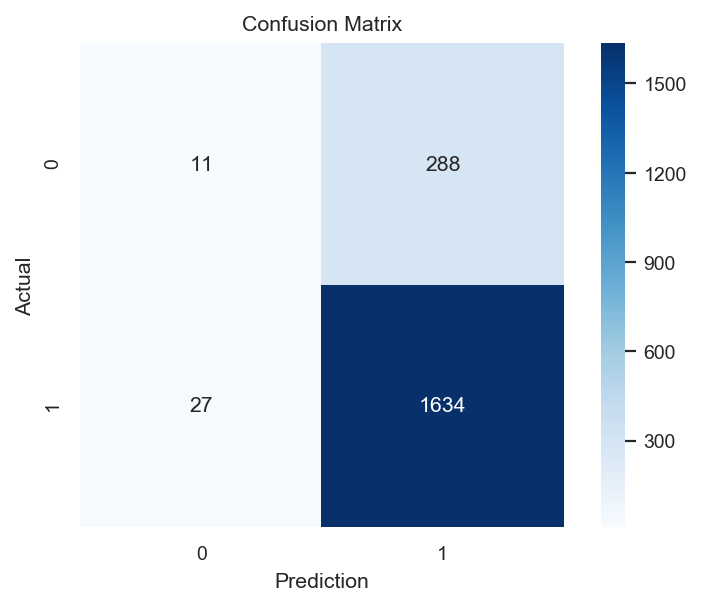

In [40]:
make_confusion_matrix(knn)

### Logistic Regression Model

In [49]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print("Scores for Logistic Regression")
print("Training: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test, y_test)))
f1_score(lr.predict(X_test), y_test)

The score for logistic regression is
Training:  84.51%
Test set:  84.23%


0.9141428174492915

In [ ]:
#F1 score close to 1 means model is close to balanced between Precision & Recall

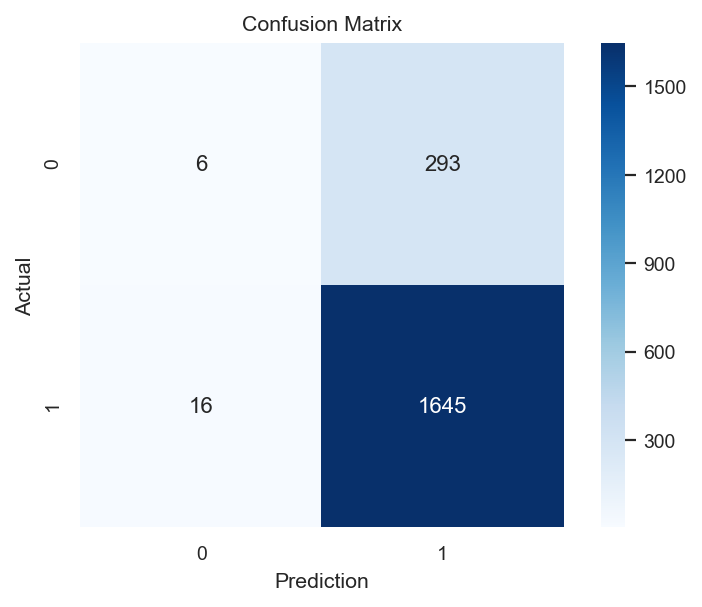

In [50]:
make_confusion_matrix(lr)

### Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
print("Scores for Naive Bayes")
print("Training: {:6.2f}%".format(100*nb.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*nb.score(X_test, y_test)))
f1_score(nb.predict(X_test), y_test)

Scores for Naive Bayes
Training:  83.92%
Test set:  83.98%


0.9118967452300786

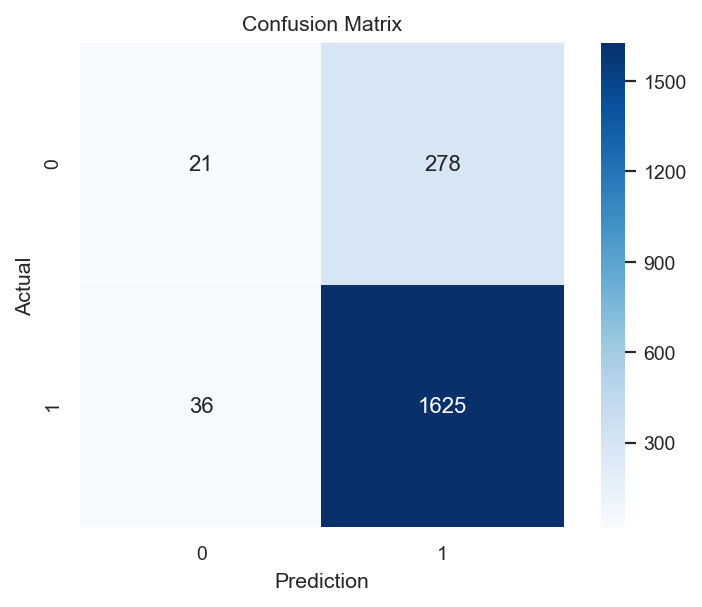

In [52]:
make_confusion_matrix(nb)

### Linear SVM

In [60]:
from sklearn.svm import SVC

lin_svc = SVC(kernel="linear", gamma="auto")
lin_svc.fit(X_train, y_train)
print("Scores for Linear SVM")
print("Training: {:6.2f}%".format(100*lin_svc.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lin_svc.score(X_test, y_test)))
f1_score(lin_svc.predict(X_test), y_test)

Scores for Linear SVM
Training:  85.02%
Test set:  84.74%


0.9174261253797293

### RBF SVM

In [59]:
from sklearn.svm import SVC

rbf_svc = SVC(kernel="rbf", gamma="auto")
rbf_svc.fit(X_train, y_train)
print("Scores for RBF SVM")
print("Training: {:6.2f}%".format(100*rbf_svc.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rbf_svc.score(X_test, y_test)))
f1_score(rbf_svc.predict(X_test), y_test)

Scores for RBF SVM
Training:  90.75%
Test set:  84.39%


0.9127708095781072

### Poly SVM

In [ ]:
from sklearn.svm import SVC

poly_svc = SVC(kernel="poly", gamma="auto")
poly_svc.fit(X_train, y_train)
print("Scores for Poly SVM")
print("Training: {:6.2f}%".format(100*poly_svc.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*poly_svc.score(X_test, y_test)))
f1_score(poly_svc.predict(X_test), y_test)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rForest = RandomForestClassifier(n_estimators=100)
rForest.fit(X_train, y_train)
print("Scores for Random Forest")
print("Training: {:6.2f}%".format(100*rForest.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rForest.score(X_test, y_test)))
f1_score(rForest.predict(X_test), y_test)

### ROC Curve

In [ ]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

# predict probabilities, keep probabilities for the positive outcome only

#KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))

#Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
print("LR ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

#Naive Bayes
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
print("Naive Bayes ROC AUC score = ", roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1]))

#Linear SVM
#fpr_lin_svc, tpr_lin_svc, thresholds_lin_svc = roc_curve(y_test, lin_svc.predict_proba(X_test)[:, 1])
#print("Linear SVM ROC AUC score = ", roc_auc_score(y_test, lin_svc.predict_proba(X_test)[:, 1]))

#RBF SVM
#fpr_rbf_svc, tpr_rbf_svc, thresholds_rbf_svc = roc_curve(y_test, rbf_svc.predict_proba(X_test)[:, 1])
#print("RBF SVM ROC AUC score = ", roc_auc_score(y_test, rbf_svc.predict_proba(X_test)[:, 1]))

#Poly SVM
#fpr_poly_svc, tpr_poly_svc, thresholds_poly_svc = roc_curve(y_test, poly_svc.predict_proba(X_test)[:, 1])
#print("Poly SVM ROC AUC score = ", roc_auc_score(y_test, poly_svc.predict_proba(X_test)[:, 1]))

#Random Forest
#fpr_rForest, tpr_rForest, thresholds_rForest = roc_curve(y_test, rForest.predict_proba(X_test)[:, 1])
#print("Random Forest ROC AUC score = ", roc_auc_score(y_test, rForest.predict_proba(X_test)[:, 1]))


In [ ]:
#knn
plt.plot(fpr_knn, tpr_knn, c='r', lw=2)
#logistic
plt.plot(fpr_lr, tpr_lr, c='o', lw=2)
#naive bayes
plt.plot(fpr_nb, tpr_nb, c='y', lw=2)
#linear svm
#plt.plot(fpr_lin_svc, tpr_lin_svc, c='g', lw=2)
#rbf svm
#plt.plot(fpr_rbf_svc, tpr_rbf_svc, c='b', lw=2)
#poly svm
#plt.plot(fpr_poly_svc, tpr_poly_svc, c='c', lw=2)
#random forest
#plt.plot(fpr_rForest, tpr_rForest, c='k', lw=2)

# plot no-skill line
plt.plot([0,1],[0,1],c='violet',ls='--')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');


#### Upsampling

In [43]:
#Definitely need to upsample
#If always guessed "Success", would be right 85% of the time
rest_with_dummies.Success.value_counts(normalize=True)

1    0.849357
0    0.150643
Name: Success, dtype: float64

We'll definitely want to account for the imbalance later (though not in this notebook) when we try to optimize our F1 score, the chosen metric for scoring our model.

In [ ]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [ ]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

#### Log-Loss Cross-Entropy

>- Log-loss allows us to measure not just "did our model get XYZ right?" but "how confident was it in when predicting?"
>
>- A lower log-loss is better


In [ ]:
from sklearn.metrics import log_loss

print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, lm.predict_proba(X_test))))

#### Compare models against Dummy Classifier (random guessing)

In [ ]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier()
dc.fit(X_train, y_train)
print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_test, dc.predict_proba(X_test))))

In [ ]:
print("Logistic accuracy: {:6.4f}".format(lm.score(X_test, y_test)))
print("Dummy accuracy: {:6.4f}".format(dc.score(X_test, y_test)))